In [1]:
import pandas as pd
import numpy as np
import re
import string

In [2]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, SpatialDropout1D, Conv1D,MaxPool1D,BatchNormalization, GRU, SimpleRNN, Dropout,Flatten, concatenate,Bidirectional, GlobalMaxPool1D
from tensorflow.keras import utils 
from sklearn.model_selection import train_test_split
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
import matplotlib.pyplot as plt 
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import random
import time
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import brown
from textblob import TextBlob
from tensorflow.keras import regularizers
from keras.initializers import Constant


In [3]:


import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('ggplot')
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)



In [4]:
#Cargamos dataset train en un dataframe
tweets_train = pd.read_csv('Dataset/train.csv')
tweets_test = pd.read_csv('Dataset/test.csv')
tweets_submission = pd.read_csv('Dataset/sample_submission.csv') 

In [5]:
tweets_train.text

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [7]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [8]:
tweets_train['cleaned_text'] = tweets_train['text'].apply(lambda x: clean_text(x))

In [9]:
tweets_test['cleaned_text'] = tweets_test['text'].apply(lambda x: clean_text(x))

In [10]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
tweets_train['cleaned_text']=tweets_train['cleaned_text'].apply(lambda x: remove_emoji(x))

In [11]:
train_text_emb = tweets_train.cleaned_text
test_emb = tweets_test.cleaned_text
train_target_emb = tweets_train.target

In [12]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_text_emb)
vocab_length = len(word_tokenizer.word_index) + 1

In [13]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [14]:
longest_train = max(train_text_emb, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train_text_emb), length_long_sentence, padding='post')
test_sentences = pad_sequences(embed(test_emb), length_long_sentence, padding='post')

In [28]:
vocab_length

16834

In [20]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('Dataset/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [18]:
#embeddings_dictionary

In [29]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [30]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.27085999,  0.044006  , -0.02026   , ..., -0.4923    ,
         0.63687003,  0.23642001],
       ...,
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.25161999,  0.73246998,  0.30792999, ..., -0.89315999,
         1.29760003, -0.04898   ],
       [-0.17609   , -0.049419  ,  0.28481001, ..., -1.47909999,
         0.53746998, -0.64883   ]])

In [31]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [32]:
y = np.asarray(train_target_emb)

In [33]:
xTrain, xVal, yTrain, yVal = train_test_split(padded_sentences, y, test_size=0.25)

In [34]:
xVal.shape

(1904, 31)

In [35]:
model = BLSTM()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(xTrain,yTrain,epochs=10,batch_size=32, validation_data=(xVal, yVal), verbose = 1, callbacks = [checkpoint, reduce_lr])

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.7131 - accuracy: 0.6195
Epoch 00001: val_loss improved from inf to 0.61523, saving model to model.h5
179/179 [==============================] - 8s 44ms/step - loss: 0.7131 - accuracy: 0.6195 - val_loss: 0.6152 - val_accuracy: 0.7952
Epoch 2/10
179/179 [==============================] - ETA: 0s - loss: 0.5670 - accuracy: 0.7269
Epoch 00002: val_loss improved from 0.61523 to 0.50735, saving model to model.h5
179/179 [==============================] - 7s 41ms/step - loss: 0.5670 - accuracy: 0.7269 - val_loss: 0.5073 - val_accuracy: 0.7820
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.7719
Epoch 00003: val_loss improved from 0.50735 to 0.44255, saving model to model.h5
179/179 [==============================] - 7s 41ms/step - loss: 0.5203 - accuracy: 0.7719 - val_loss: 0.4426 - val_accuracy: 0.8036
Epoch 4/10
178/179 [============================>.] - ETA: 0s - loss: 0.4723 

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 31, 100)           1683400   
_________________________________________________________________
bidirectional (Bidirectional (None, 31, 62)            32736     
_________________________________________________________________
global_max_pooling1d (Global (None, 62)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62)                248       
_________________________________________________________________
dropout (Dropout)            (None, 62)                0         
_________________________________________________________________
dense (Dense)                (None, 31)                1953      
_________________________________________________________________
dropout_1 (Dropout)          (None, 31)                0

In [37]:
import matplotlib.pyplot as plt
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)


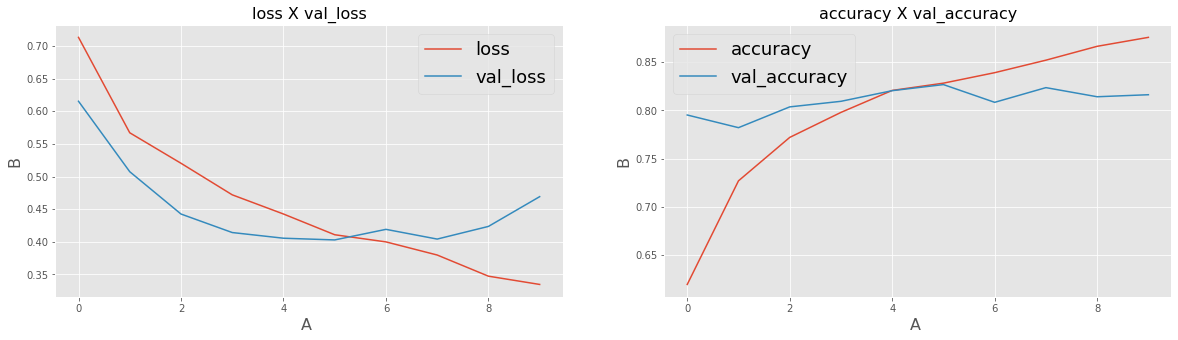

In [38]:


plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])



In [41]:
model.load_weights('model.h5')
preds = model.predict_classes(xVal)


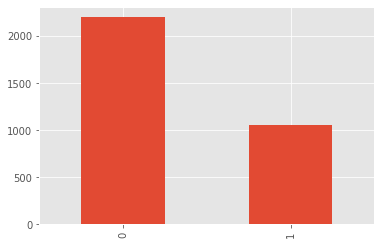

In [42]:
tweets_submission.target = model.predict_classes(test_sentences)
tweets_submission.to_csv("submission.csv", index=False)
tweets_submission.target.value_counts().plot.bar();